In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import tensorflow.examples.tutorials.mnist.input_data as input_data
import matplotlib.pyplot as plt

In [2]:
def montage_batch(images):
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    m = np.ones(
        (images.shape[1] * n_plots + n_plots + 1,
         images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5

    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter, ...]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w, :] = this_img
    return m

def montage(W):
    W = np.reshape(W, [W.shape[0], W.shape[1], 1, W.shape[2] * W.shape[3]])
    n_plots = int(np.ceil(np.sqrt(W.shape[-1])))
    m = np.ones(
        (W.shape[0] * n_plots + n_plots + 1,
         W.shape[1] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < W.shape[-1]:
                m[1 + i + i * W.shape[0]:1 + i + (i + 1) * W.shape[0],
                  1 + j + j * W.shape[1]:1 + j + (j + 1) * W.shape[1]] = (
                    np.squeeze(W[:, :, :, this_filter]))
    return m

def corrupt(x):
    return tf.mul(x, tf.cast(tf.random_uniform(shape=tf.shape(x),
                                               minval=0,
                                               maxval=2,
                                               dtype=tf.int32), tf.float32))

def weight_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.01)
    return tf.Variable(initial)


def VAE(input_shape=[None, 784],
        n_components_encoder=1024,
        n_components_decoder=1024,
        n_hidden=2,
        debug=False):

    # Input placeholder
    if debug:
        input_shape = [50, 784]
        x = tf.Variable(np.zeros((input_shape), dtype=np.float32))
    else:
        x = tf.placeholder(tf.float32, input_shape)

    activation = tf.nn.softplus

    dims = x.get_shape().as_list()
    n_features = dims[1]

    W_enc1 = weight_variable([n_features, n_components_encoder])
    b_enc1 = bias_variable([n_components_encoder])
    h_enc1 = activation(tf.matmul(x, W_enc1) + b_enc1)

    W_enc2 = weight_variable([n_components_encoder, n_components_encoder])
    b_enc2 = bias_variable([n_components_encoder])
    h_enc2 = activation(tf.matmul(h_enc1, W_enc2) + b_enc2)

    W_enc3 = weight_variable([n_components_encoder, n_components_encoder])
    b_enc3 = bias_variable([n_components_encoder])
    h_enc3 = activation(tf.matmul(h_enc2, W_enc3) + b_enc3)

    W_mu = weight_variable([n_components_encoder, n_hidden])
    b_mu = bias_variable([n_hidden])

    W_log_sigma = weight_variable([n_components_encoder, n_hidden])
    b_log_sigma = bias_variable([n_hidden])

    z_mu = tf.matmul(h_enc3, W_mu) + b_mu
    z_log_sigma = 0.5 * (tf.matmul(h_enc3, W_log_sigma) + b_log_sigma)

    # Sample from noise distribution p(eps) ~ N(0, 1)
    if debug:
        epsilon = tf.random_normal(
            [dims[0], n_hidden])
    else:
        epsilon = tf.random_normal(
            tf.pack([tf.shape(x)[0], n_hidden]))

    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon

    W_dec1 = weight_variable([n_hidden, n_components_decoder])
    b_dec1 = bias_variable([n_components_decoder])
    h_dec1 = activation(tf.matmul(z, W_dec1) + b_dec1)

    W_dec2 = weight_variable([n_components_decoder, n_components_decoder])
    b_dec2 = bias_variable([n_components_decoder])
    h_dec2 = activation(tf.matmul(h_dec1, W_dec2) + b_dec2)

    W_dec3 = weight_variable([n_components_decoder, n_components_decoder])
    b_dec3 = bias_variable([n_components_decoder])
    h_dec3 = activation(tf.matmul(h_dec2, W_dec3) + b_dec3)

    W_mu_dec = weight_variable([n_components_decoder, n_features])
    b_mu_dec = bias_variable([n_features])
    y = tf.nn.tanh(tf.matmul(h_dec3, W_mu_dec) + b_mu_dec)

    # p(x|z)
    log_px_given_z = -tf.reduce_sum(
        x * tf.log(y + 1e-10) +
        (1 - x) * tf.log(1 - y + 1e-10), 1)

    # d_kl(q(z|x)||p(z))
    # Appendix B: 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_div = -0.5 * tf.reduce_sum(
        1.0 + 2.0 * z_log_sigma - tf.square(z_mu) - tf.exp(2.0 * z_log_sigma),  1)
    loss = tf.reduce_mean(log_px_given_z + kl_div)

    return {'cost': loss, 'x': x, 'z': z, 'y': y}


Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Epoch :  1
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Minitbatch Loss : nan
Min

KeyboardInterrupt: 

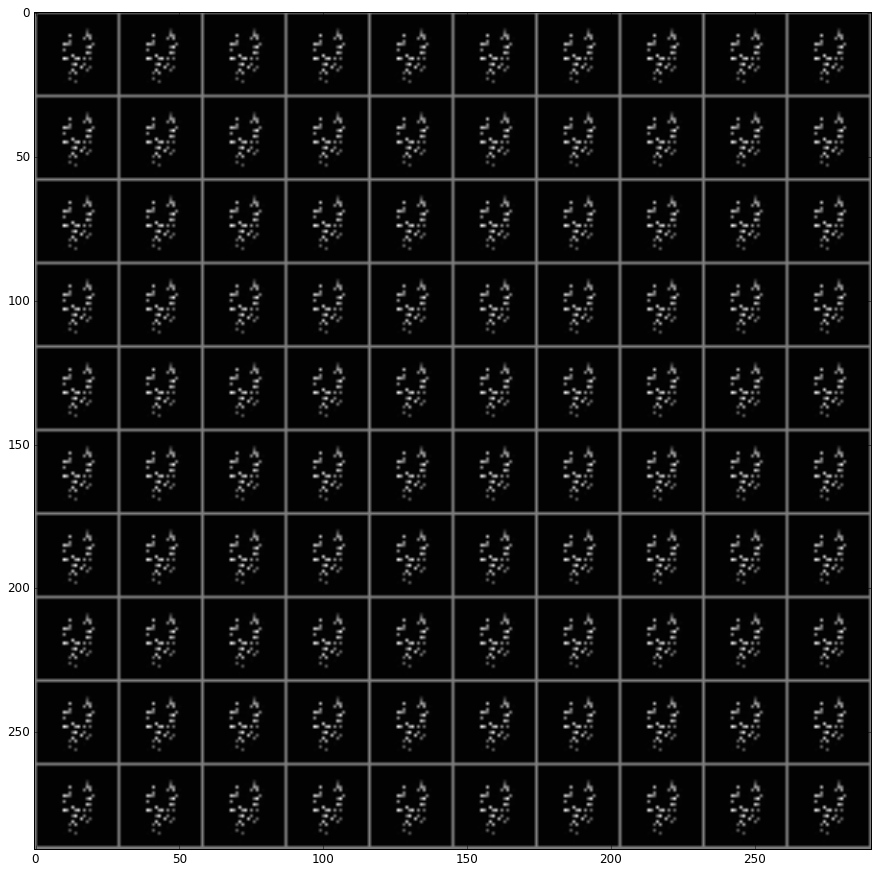

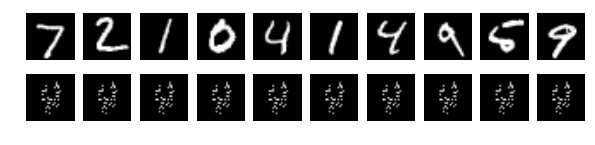

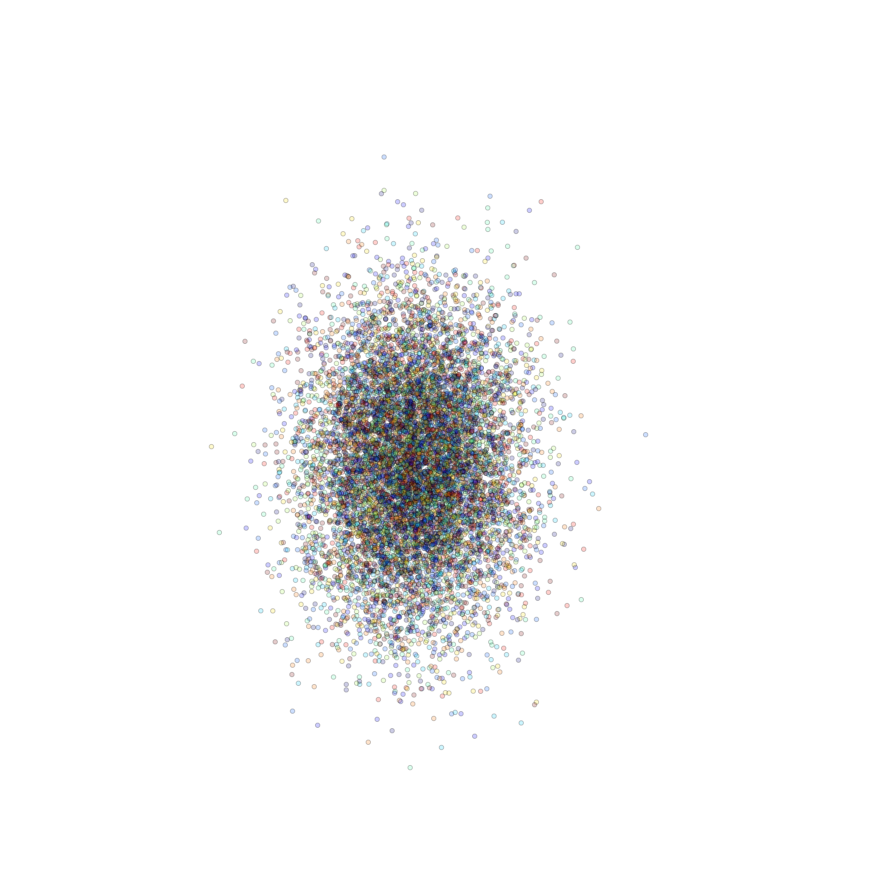

In [3]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
ae = VAE()

learning_rate = 0.001
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(ae['cost'])

# We create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Fit all training data
t_i = 0
batch_size = 64
n_epochs = 50
n_examples = 10
test_xs, _ = mnist.test.next_batch(n_examples)
xs, ys = mnist.test.images, mnist.test.labels
fig_manifold, ax_manifold = plt.subplots(1, 1)
fig_reconstruction, axs_reconstruction = plt.subplots(2, n_examples, figsize=(10, 2))
fig_image_manifold, ax_image_manifold = plt.subplots(1, 1)

for epoch_i in range(n_epochs):
    print('Epoch : ', epoch_i + 1)
    train_cost = 0
    for batch_i in range(mnist.train.num_examples // batch_size):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        train_cost += sess.run([ae['cost'], optimizer], feed_dict={ae['x']: batch_xs})[0]
        print("Minitbatch Loss :", train_cost)
        
        if batch_i % 10 == 0:
            # Plot example reconstructions from latent layer
            imgs = []
            for img_i in np.linspace(-3, 3, n_examples):
                for img_j in np.linspace(-3, 3, n_examples):
                    z = np.array([[img_i, img_j]], dtype=np.float32)
                    recon = sess.run(ae['y'], feed_dict={ae['z']: z})
                    imgs.append(np.reshape(recon, (1, 28, 28, 1)))
            imgs_cat = np.concatenate(imgs)
            ax_manifold.imshow(montage_batch(imgs_cat))
            fig_manifold.savefig('./vae_img/manifold_%08d.png' % t_i)

            # Plot example reconstructions
            recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs})
            for example_i in range(n_examples):
                axs_reconstruction[0][example_i].imshow(
                    np.reshape(test_xs[example_i, :], (28, 28)),cmap='gray')
                axs_reconstruction[1][example_i].imshow(
                    np.reshape(np.reshape(recon[example_i, ...], (784,)), (28, 28)), cmap='gray')
                axs_reconstruction[0][example_i].axis('off')
                axs_reconstruction[1][example_i].axis('off')
            fig_reconstruction.savefig('./vae_img/reconstruction_%08d.png' % t_i)

            # Plot manifold of latent layer
            zs = sess.run(ae['z'], feed_dict={ae['x']: xs})
            ax_image_manifold.clear()
            ax_image_manifold.scatter(zs[:, 0], zs[:, 1], c=np.argmax(ys, 1), alpha=0.2)
            ax_image_manifold.set_xlim([-6, 6])
            ax_image_manifold.set_ylim([-6, 6])
            ax_image_manifold.axis('off')
            fig_image_manifold.savefig('./vae_img/image_manifold_%08d.png' % t_i)

            t_i += 1

    print('Train cost:', train_cost / (mnist.train.num_examples // batch_size))

    valid_cost = 0
    for batch_i in range(mnist.validation.num_examples // batch_size):
        batch_xs, _ = mnist.validation.next_batch(batch_size)
        valid_cost += sess.run([ae['cost']], feed_dict={ae['x']: batch_xs})[0]
    print('Validation cost:', valid_cost / (mnist.validation.num_examples // batch_size))